# Kalman Filterin' 2: Electric Boogaloo
### SCJ Robertson

An Extended Kalman Filter (EKF) will be used to track a golf ball in cartesain coordinates. The measurements are a Range-Doppler map for each of EMSS's detectors at a given time instance. The golf ball's position in cartesian coordinates is then determined using multilateration. Multilateration ensures the measurement model is non-linear forcing the use of the EKF, even if the system model is assumed to be linear.

As of yet there is no actual measured data, therefore the Range-Doppler measurements must be simulated.

In [57]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pylab as plt
from mpl_toolkits import mplot3d
from calc_traj import calc_traj
from range_doppler import range_doppler
from util import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Golf ball flight dynamics 
The following section documents the development of a model for golf ball flight dynamics, it is largely based off EMSS's own investigations.

<img src="forces.png" scale=0.25>
<center> <b> Figure 1: Force diagram of a golf ball. $\mathbf{v}$ is the velocity vector and not a force. </b> </center>

Ignoring all external influences, Figure 1 depicts the principle forces acting a golf ball in flight. These forces are assumed to be those with the largest influence on the golf ball's trajectory. The forces are:

* $\mathbf{F}_D$: The drag force is opposed to the velocity $\mathbf{v}$, its magnitude for a given component is determined by $$F_{D} = \frac{1}{2} C_{D} \rho A |v|^{2}$$ $\rho$ is the density of the air and $A$ golf ball's cross sectional area. The drag coefficient, $C_{D}$, is itself a function of both the ball's linear and angular speed. 

* $\mathbf{F}_{L}$: The lift force is perpendicular to linear and rotational velocity, thus determined by a cross product. Its magnitude for a given component is determined by $$F_{L} = \frac{1}{2} C_{L} \rho A |v|^{2}$$ The lift coefficient, $C_{L}$, is itself a function of both the ball's linear and angular speed. 

* $m\mathbf{g}$: Gravity, it goes downwards.

Applying Newton's second law, $$\mathbf{a} = \frac{1}{m} \sum \mathbf{F}$$ and simplifying results in the following system of ODES:

$$ \begin{eqnarray} 
\frac{d^2x}{dt^2} &=& -\frac{\rho A |v|}{2m} (C_{D}v_{x} - C_{L}[\frac{\omega_y}{|\omega|}v_z - \frac{\omega_y}{|\omega|}v_y])  \\  
\frac{d^2y}{dt^2} &=& -g -\frac{\rho A |v|}{2m} (C_{D}v_{y} - C_{L}[\frac{\omega_z}{|\omega|}v_x - \frac{\omega_x}{|\omega|}v_z]) \\ 
\frac{d^2z}{dt^2} &=& -\frac{\rho A |v|}{2m} (C_{D}v_{z} - C_{L}[\frac{\omega_x}{|\omega|}v_y - \frac{\omega_y}{|\omega|}v_x]) 
\end{eqnarray}$$

This system assumes a linear rate of decay for the spin, which is described the following system of equations:

$$ \begin{eqnarray}
\frac{d\omega_x}{dt} &=& -SRD \frac{\omega_x |v|}{R} \\
\frac{d\omega_y}{dt} &=& -SRD \frac{\omega_y |v|}{R} \\
\frac{d\omega_z}{dt} &=& -SRD \frac{\omega_z |v|}{R}
\end{eqnarray} $$

$R$ is the radius of the golf ball.

<b> Remark </b>: <i> It is convention set the $y$-axis as elevation allowing the spin rate to be positive for back spin . This leads to a constant interchange of $y$ and $z$ axes for launch and direction angle calculations; however; this can be abstracted away.</i>

Here SRD, $C_{D}$ and $C_{L}$ are given by their empirical equations:

$$ \begin{eqnarray}
C_{D} &=& C_{D1} + C_{D2} + C_{D3} \sin(\pi [R_{e} - A_{1}]/A_{2}) \\
R_{e} &=& \frac{\rho |v| L}{\mu} \\
C_{L} &=& C_{L1} S^{0.45} \\
SRD &=& R_{1} S \\
S &=& \frac{ |\omega| R}{|v|}
\end{eqnarray} $$

It can be seen the drag coefficient depends on the object's shape and Reynolds number, $R_{e}$, and the lift coefficient on the spin rate factor, $S$. The values of the constants $C_{D1}$, $C_{D2}$, $C_{L1}$, $\mu$, $R$, $R_{1}$, $A_{1}$ and $A_{2}$ can be found in the <b>calc_traj.py</b> module.

<b> Remark </b>: <i> EMSS's documentation shows the model is reasonably accurate when compared to the PGA tour measurements; however it requires the subtle tweaking of several parameters which aren't mentioned in the documentation. This model will not be used as the Kalman filter's system model but it will be used to generate the golf ball's simualted trajectory. This trajectory will then be used to simulate Range-Doppler measurements which via multilateration will be converted back to its cartesian coordinates.</i>


### Simulation

The system of ODES can be solved using the function <b>calc_traj</b> in the <b>calc_traj.py</b> module. The initial conditions for the various clubs can be found in the <i>clubs.csv</i> file.

In [58]:
names, p0, v0, w0 = load_clubs('clubs.csv')

N = len(names)
t = np.arange(0, 12, 0.001)

<table> 

    <tr>
        <th>Club</th>
        <th>Launch angle ($^{\circ}$)</th>
        <th>Speed (m/s)</th>
        <th>Spin (RPM)</th>
        <th>Maximum height (m)</th>
        <th>Simulated height (m)</th>
        <th>Maximum carry (m)</th>
        <th>Simulated carry (m)</th>
    </tr>
    
    <tr>
        <th>Driver</th>
        <th>10.9</th>
        <th>74.2</th>
        <th>2686</th>
        <th>29.2</th>
        <th>31.37</th>
        <th>251.46</th>
        <th>240.79</th>
    </tr>
    
    <tr>
        <th>3-Wood</th>
        <th>9.2</th>
        <th>70.2</th>
        <th>3655</th>
        <th>27.43</th>
        <th>28.81</th>
        <th>222.20</th>
        <th>230.44</th>
    </tr>
    
    
</table>

<center> <b>Table 1: A comparison of PGA tour measurements and model outputs for various club types.</b> </center>

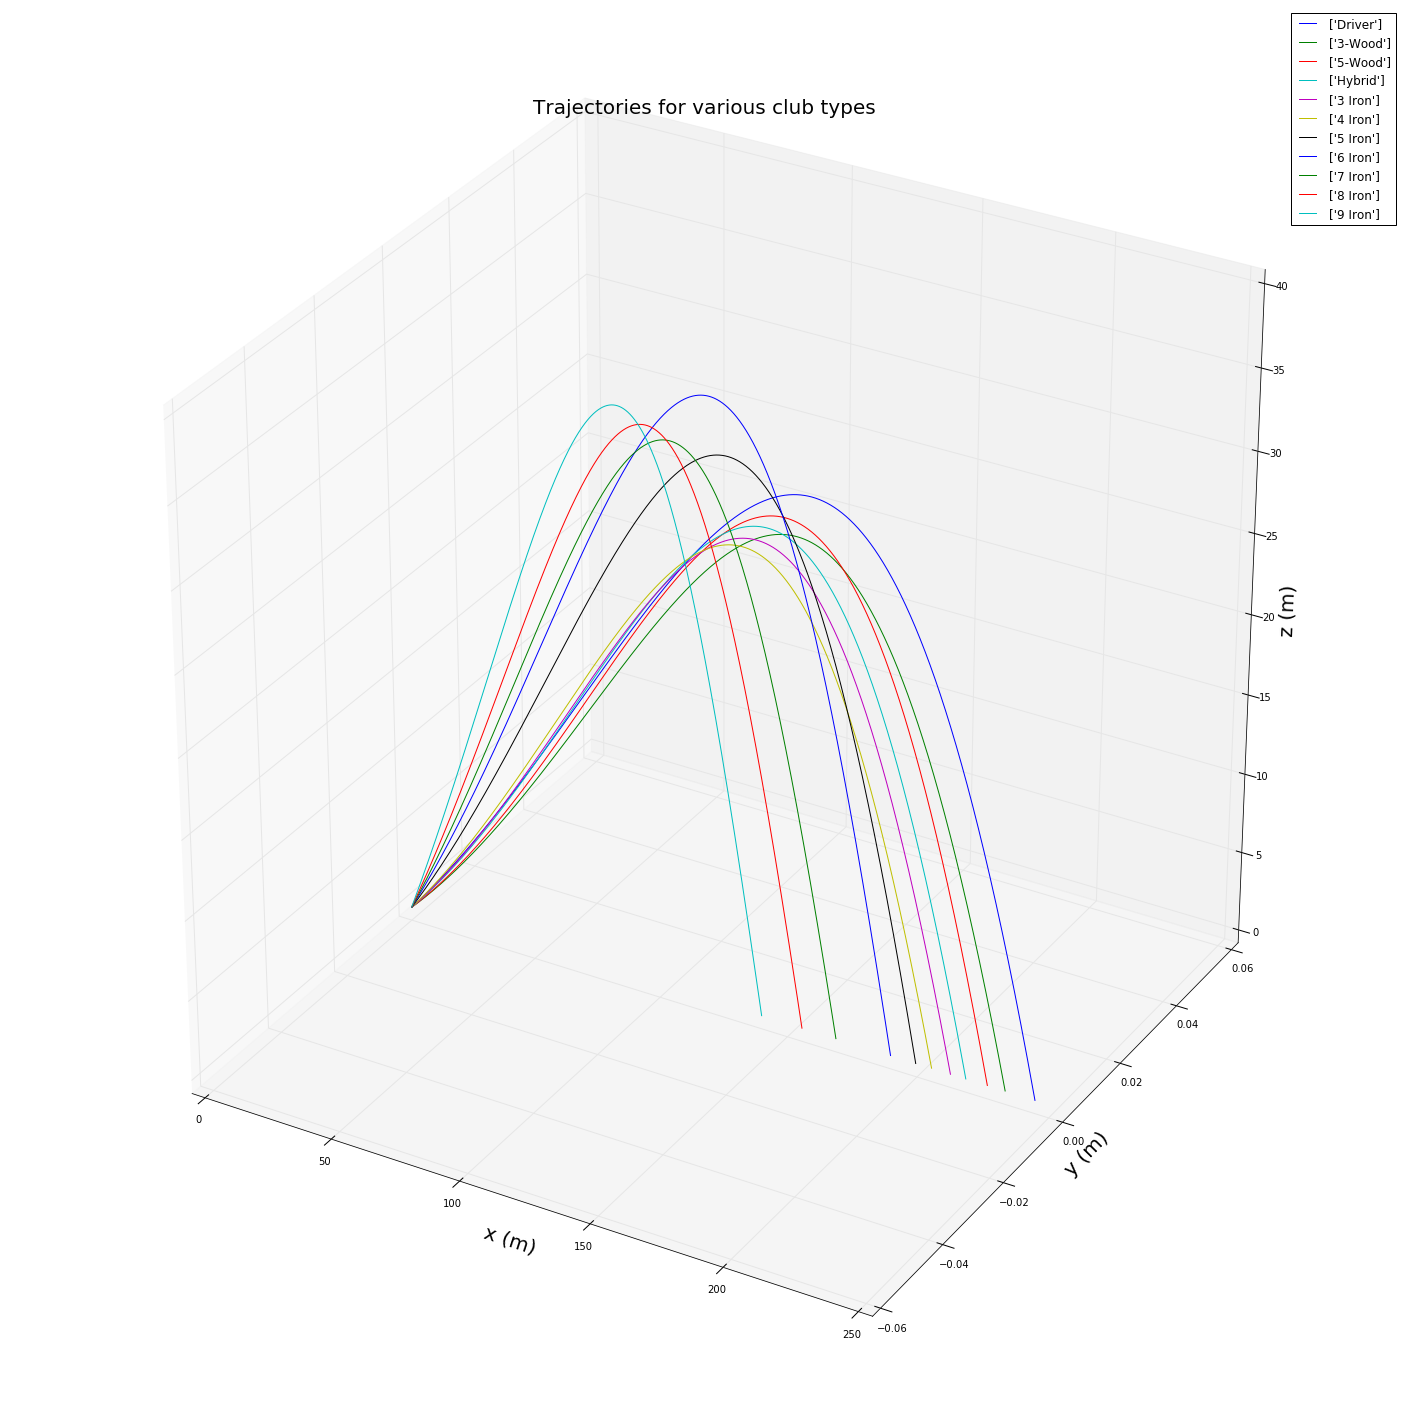

In [59]:
fig  = plt.figure(figsize=(25, 25))
ax = plt.axes(projection='3d')

for i in np.arange(0, N-1):
    _, f, _ = calc_traj(p0[i, :], v0[i, :], w0[i, :], t)
    ax.plot(f[:, 0], f[:, 1], f[:, 2])
  
ax.set_xlabel('x (m)', fontsize = '20')
ax.set_ylabel('y (m)', fontsize = '20')
ax.set_zlabel('z (m)', fontsize = '20')
ax.set_title('Trajectories for various club types', fontsize = '20')
ax.legend(names)
plt.show()

## The Range-Doppler Domain

In [164]:
sensor_locations = np.array([[-10, 28.5, 1], [-15, 30.3, 3],
                            [200, 30, 1.5], [220, -31, 2],
                            [-30, 0, 0.5], [150, 10, 0.6]])
cpi = 40e-3
t_sim = np.arange(0, 12, cpi)
_, p, v = calc_traj(p0[0, :], v0[0, :], w0[0, :], t_sim)

In [165]:
r_d = range_doppler(sensor_locations, p, v)

print r_d.shape

IndexError: index 2 is out of bounds for axis 2 with size 2

In [108]:
h = np.zeros((50, 3))
z = h + sensor_locations[0, :]
t = z/((z**2).sum(axis = 1)[:, np.newaxis])